## DRO Orbits playground


In [1]:
import pickle
import importlib
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import sys
import numpy as np
import datetime
import scipy.signal
import urllib
import json
import os   
import time
import h5py
import pytz
import copy
import cdflib
import sunpy
import pickle
from datetime import datetime
import seaborn as sns

from scipy.integrate import solve_ivp

from matplotlib.ticker import MultipleLocator

import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.express as px
pio.renderers.default = 'browser'

import astropy.constants as const
import astropy.units as u

##### check for system type
#server
if sys.platform == 'linux': 
    print('system is linux')
    matplotlib.use('Agg') 
#mac
if sys.platform =='darwin':  
    print('system is mac')
    #for testing
    %matplotlib inline     
    #matplotlib.use('Agg') 

au=const.au.value*1e-3



from astropy import constants as const
from astropy import units as u
from scipy.integrate import solve_ivp

print('Au in km:',au) # in km

M_sun = const.M_sun  # Sun mass
M_earth = const.M_earth   # Earth mass

# Sun-Earth system parameters mu: mass parameter (m2/(m1+m2))
mu = M_earth/(M_sun+M_earth)  # Earth mass / (Sun + Earth mass)
print('mu is:',mu)

#make sure to convert the current notebook to a script
#os.system('jupyter nbconvert --to script positions_3d.ipynb')   

#test execution times
clock_start = time.time()


system is mac
Au in km: 149597870.70000002
mu is: 3.003480327929619e-06


### load planetary orbits

In [2]:
[psp, bepi, solo, sta, juice, earth, mercury, venus, mars, jupiter, saturn, uranus, neptune,l4,l5]=pickle.load( open( 'results/positions/positions_2020_all_HEEQ_1h_rad_cm.p', "rb" ) )   

start=mdates.date2num(datetime(2028,1,1))
end=mdates.date2num(datetime(2030,1,1))

#select the timerange
startind=np.argmin(abs(start-earth.time))
endind=np.argmin(abs(end-earth.time))
earth=earth[startind:endind]

startind=np.argmin(abs(start-venus.time))
endind=np.argmin(abs(end-venus.time))
venus=venus[startind:endind]

startind=np.argmin(abs(start-mercury.time))
endind=np.argmin(abs(end-mercury.time))
mercury=venus[startind:endind]

### CR3BP simulation (circular restricted 3 Body Problem)

equations adapted from https://jan.ucc.nau.edu/~ns46/student/2010/Frnka_2010.pdf

In [3]:
# Physical constants
G = 6.67430e-20  # Gravitational constant in km^3/(kg*s^2)
M_sun = 1.989e30  # kg
M_earth = 5.972e24  # kg
R = 1.496e8  # Earth-Sun distance in km

# Calculate system parameters
M_total = M_sun + M_earth
mu = M_earth / M_total  # Mass parameter
omega = np.sqrt(G * M_total / R**3)  # Angular velocity of rotating frame (rad/s)

print(f"System Parameters:")
print(f"  Mass parameter μ = {mu:.6e}")
print(f"  Earth-Sun distance R = {R:.6e} km")
print(f"  Angular velocity ω = {omega:.6e} rad/s")
print(f"  Orbital period = {2*np.pi/omega/86400:.2f} days\n")

def cr3bp_equations(t, state):
    """
    Equations of motion for the Circular Restricted 3-Body Problem
    in the rotating reference frame with physical units.    
    state = [x, y, vx, vy] in km and km/s
    """
    x, y, vx, vy = state
    
    # Positions of the primaries in rotating frame
    x1 = -mu * R  # Sun position
    x2 = (1 - mu) * R  # Earth position
    
    # Distances to the two primaries
    r1 = np.sqrt((x - x1)**2 + y**2)
    r2 = np.sqrt((x - x2)**2 + y**2)
    
    # need to check these equations with Frnka 2010
    ax = (2*omega*vy + omega**2*x - G*M_sun*(x - x1)/r1**3 - G*M_earth*(x - x2)/r2**3)    
    ay = (-2*omega*vx + omega**2*y - G*M_sun*y/r1**3 - G*M_earth*y/r2**3)
    
    return [vx, vy, ax, ay]



def make_dro(initial_state):

    # Time span for integration (in seconds)
    years=2
    days = 365*years  # Simulate for 1 year
    t_span = (0, days * 86400)
    t_eval = np.linspace(t_span[0], t_span[1], days) #time resolution of 1 day

    print("Integrating trajectory...")
    # Solve the differential equations
    solution = solve_ivp(cr3bp_equations, t_span, initial_state,  t_eval=t_eval, method='DOP853', rtol=1e-10, atol=1e-8)

    # Extract trajectory, convert to au
    x = solution.y[0]/au; y = solution.y[1]/au

    return x,y


System Parameters:
  Mass parameter μ = 3.002505e-06
  Earth-Sun distance R = 1.496000e+08 km
  Angular velocity ω = 1.991240e-07 rad/s
  Orbital period = 365.21 days



### Numerical simulation

Integrating trajectory...
Integrating trajectory...
Integrating trajectory...
Integrating trajectory...
Integrating trajectory...


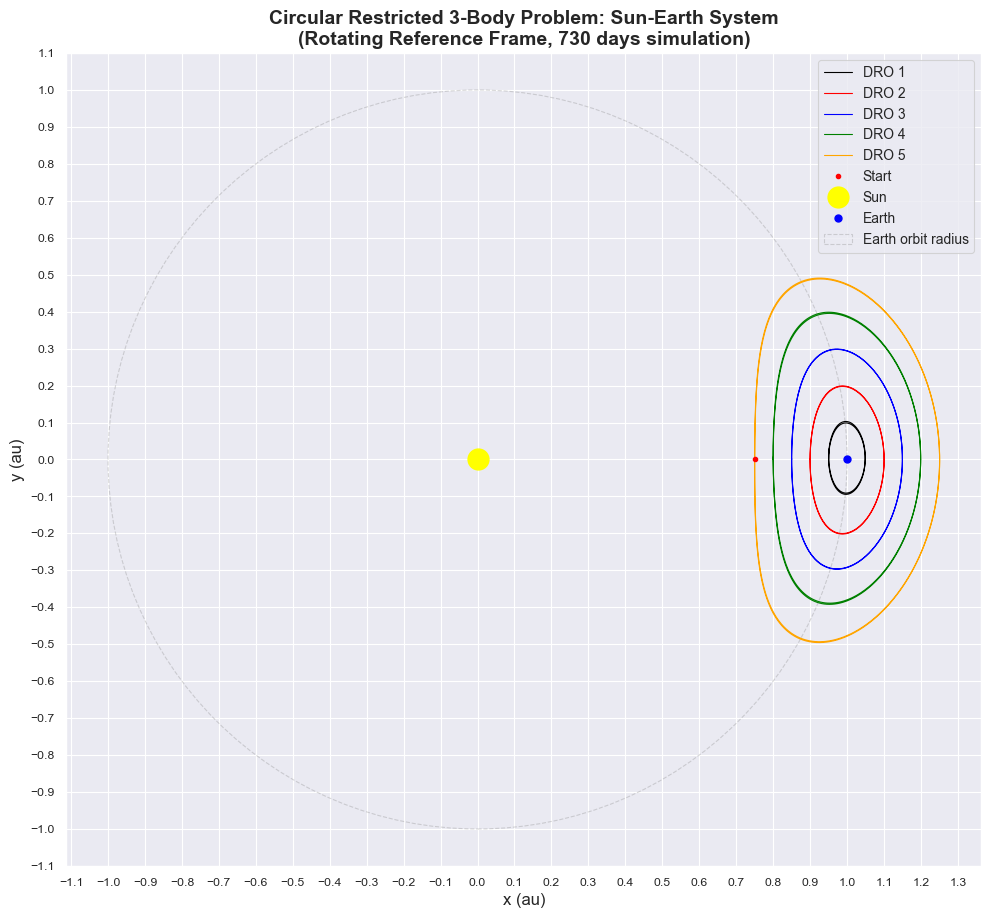

In [4]:
###################### find dro solutions by trial and error




days=365*2 ######### ****** need to add specific times for orbits

########### solution for 0.95 au is 3.03 km/s
x0 = 0.95*au  # km (between Sun and Earth)
y0 = 0  # km
vx0 = 0  # km/s
vy0 = 3.03 # km/s
[x1,y1]=make_dro([x0, y0, vx0, vy0])


########### solution for 0.9 au is 6.13 km/s
x0 = 0.90*au  # km (between Sun and Earth)
y0 = 0  # km
vx0 = 0  # km/s
vy0 = 6.13 # km/s
[x2,y2]=make_dro([x0, y0, vx0, vy0])


########### solution for 0.85 au is 9.33 km/s
x0 = 0.85*au  # km (between Sun and Earth)
y0 = 0  # km
vx0 = 0  # km/s
vy0 = 9.33 # km/s
[x3,y3]=make_dro([x0, y0, vx0, vy0])


########### solution for 0.8 au is 12.65 km/s
x0 = 0.8*au  # km (between Sun and Earth)
y0 = 0  # km
vx0 = 0  # km/s
vy0 = 12.65 # km/s
[x4,y4]=make_dro([x0, y0, vx0, vy0])

########### solution for 0.7 au is 9.33 km/s
x0 = 0.75*au  # km (between Sun and Earth)
y0 = 0  # km
vx0 = 0  # km/s
vy0 = 16.12 # km/s
[x5,y5]=make_dro([x0, y0, vx0, vy0])

initial_x0_array=[0.95, 0.90, 0.85, 0.80, 0.75]
initial_vy_array=[3.03, 6.13, 9.33, 12.65, 16.12]


############# conversion for polar plot
dro_x1=x1
dro_y1=y1
dro_r1= np.sqrt(dro_x1**2 + dro_y1**2)
dro_lon1 = np.arctan2(dro_y1, dro_x1)

dro_x2=x2
dro_y2=y2
dro_r2= np.sqrt(dro_x2**2 + dro_y2**2)
dro_lon2 = np.arctan2(dro_y2, dro_x2)

dro_x3=x3
dro_y3=y3
dro_r3= np.sqrt(dro_x3**2 + dro_y3**2)
dro_lon3 = np.arctan2(dro_y3, dro_x3)

dro_x4=x4
dro_y4=y4
dro_r4= np.sqrt(dro_x4**2 + dro_y4**2)
dro_lon4 = np.arctan2(dro_y4, dro_x4)

dro_x5=x5
dro_y5=y5
dro_r5= np.sqrt(dro_x5**2 + dro_y5**2)
dro_lon5 = np.arctan2(dro_y5, dro_x5)

#initial_conditions_array=[0


###########################################################


sns.set_style('darkgrid')
sns.set_context('paper')   
# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

#third body
ax.plot(x1, y1, 'black', linewidth=0.8, alpha=1.0, label='DRO 1')
ax.plot(x2, y2, 'red', linewidth=0.8, alpha=1.0, label='DRO 2')
ax.plot(x3, y3, 'blue', linewidth=0.8, alpha=1.0, label='DRO 3')
ax.plot(x4, y4, 'green', linewidth=0.8, alpha=1.0, label='DRO 4')
ax.plot(x5, y5, 'orange', linewidth=0.8, alpha=1.0, label='DRO 5')


ax.plot(x0/au, y0/au, 'o', color='red', markersize=3, label='Start', zorder=4)

# Plot Sun - fixed at origin shifted by -mu*R
sun_x = -mu * R / au
ax.plot(sun_x, 0, 'o', color='yellow', markersize=15, label='Sun', zorder=5)
# Plot Earth - fixed at (1-mu)*R
earth_x = (1 - mu) * R / au
ax.plot(earth_x, 0, 'o', color='blue', markersize=5, label='Earth', zorder=5)


# Add distance circles for reference
circle = plt.Circle((sun_x, 0), R/au, fill=False, color='gray', 
                    linestyle='--', alpha=0.3, label='Earth orbit radius')
ax.add_patch(circle)
# Formatting
ax.set_xlabel('x (au)', fontsize=12)
ax.set_ylabel('y (au)', fontsize=12)
ax.set_title(f'Circular Restricted 3-Body Problem: Sun-Earth System\n(Rotating Reference Frame, {days} days simulation)', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.grid(True, alpha=1.0, linestyle='-')
ax.set_aspect('equal')

plt.tight_layout()

plt.savefig('results/dro/dro_cartesian_all.png', dpi=300,bbox_inches='tight')
plt.show()

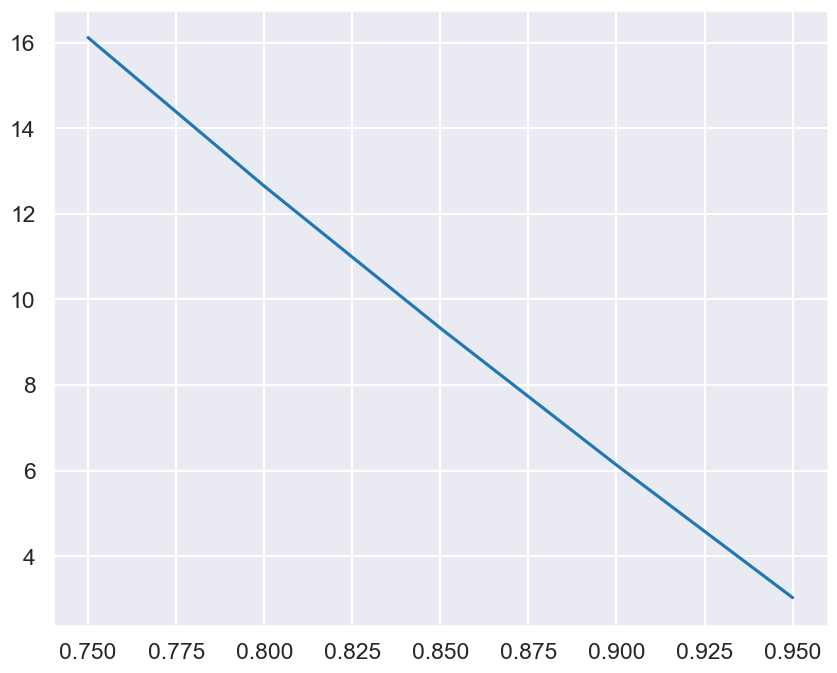

In [5]:
sns.set_style('darkgrid')
sns.set_context('talk')    
    
fig, ax = plt.subplots(1,figsize=(10, 8),dpi=100)    
    
## dependence of initial vy peed on heliocentric distance
plt.plot(initial_x0_array, initial_vy_array)


### plot combined with planets in HEEQ

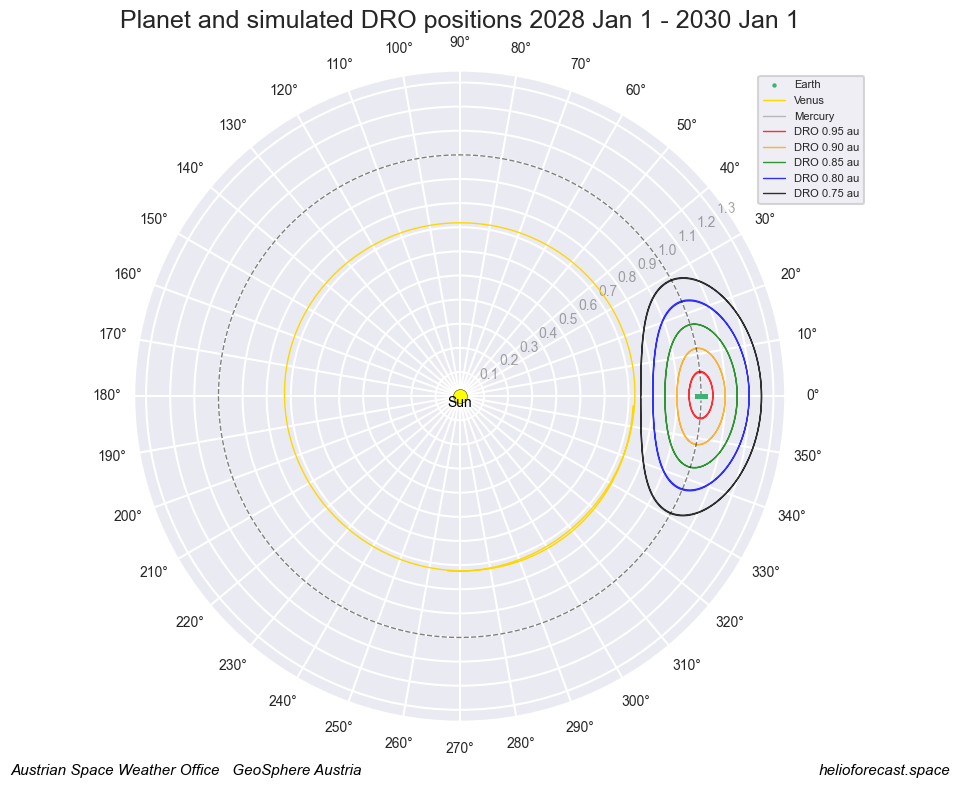

In [6]:
sns.set_style('darkgrid')
sns.set_context('talk')    
    
fig, ax = plt.subplots(1,figsize=(10, 8),subplot_kw={'projection': 'polar'},dpi=100)    
    
fsize=15
symsize_planet=10

ax.text(0,0,'Sun', color='black', ha='center',fontsize=fsize-5,verticalalignment='top')
#ax.text(0,1.2,'Earth', color='mediumseagreen', ha='center',fontsize=fsize-5,verticalalignment='center')


# Sun
ax.scatter(0,0,s=100,c='yellow',alpha=1, edgecolors='black', linewidth=0.3)
    

ax.scatter(earth.lon, earth.r, s=symsize_planet, c='mediumseagreen', alpha=1,lw=0,zorder=3,marker=None, label='Earth')  
ax.plot(venus.lon, venus.r, c='gold', alpha=1,lw=1,zorder=3, marker=None, label='Venus')  
ax.plot(mercury.lon, mercury.r, c='grey', alpha=0.5,lw=1,zorder=3, marker=None, label='Mercury')  

ax.plot(dro_lon1, dro_r1,c='red', alpha=0.8,lw=1, markersize=1, label='DRO 0.95 au')
ax.plot(dro_lon2, dro_r2,c='orange', alpha=0.8,lw=1, markersize=1, label='DRO 0.90 au')
ax.plot(dro_lon3, dro_r3,c='green', alpha=0.8,lw=1, markersize=1, label='DRO 0.85 au')
ax.plot(dro_lon4, dro_r4,c='blue', alpha=0.8,lw=1, markersize=1, label='DRO 0.80 au')
ax.plot(dro_lon5, dro_r5,c='black', alpha=0.8,lw=1, markersize=1, label='DRO 0.75 au')


#1 au circle
ax.plot(np.deg2rad(np.arange(0,360)),np.zeros(360)+1,lw=1,alpha=0.5,linestyle='--',c='black', marker=None)
     
#set axes
ax.set_theta_zero_location('E')
plt.rgrids((0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.6,2.0,2.5),('0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1.0','1.1','1.2','1.3','1.6 AU','2.0','2.5'),angle=35, fontsize=fsize-5,alpha=0.4)

degrees = np.arange(0, 360, 10)
ax.set_xticks(np.radians(degrees))
ax.set_xticklabels([f'{d}°' for d in degrees], fontsize=10)

ax.legend(bbox_to_anchor=(0.95, 1), loc='upper left',fontsize=8)

plt.title('Planet and simulated DRO positions 2028 Jan 1 - 2030 Jan 1')
ax.set_ylim(0, 1.35) 
plt.tight_layout()


plt.figtext(0.05,0.01,'Austrian Space Weather Office   GeoSphere Austria', color='black', ha='left',fontsize=fsize-4, style='italic')
plt.figtext(0.99,0.01,'helioforecast.space', color='black', ha='right',fontsize=fsize-4, style='italic')

     

plt.savefig('results/dro/dro_all_polar.png', dpi=300,bbox_inches='tight')

